In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as th

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.logger import configure

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [4]:
def make_env(repeat, env_fn, test_mode=False):
    # Create the environment
    num_machines = 8
    num_jobs = 10
    max_repeats = 5
    cost_list = [5, 1, 2, 10]
    profit_per_time = 10
    max_time = 50

    return env_fn(
        machine_config_path=f"instances/Machines/v0-{str(num_machines)}x{str(num_jobs)}.json",
        job_config_path=f"instances/Jobs/v0-{str(num_machines)}x{str(num_jobs)}.json",
        job_repeats_params=repeat,
        render_mode="seaborn",
        cost_deadline_per_time=cost_list[0],
        cost_hole_per_time=cost_list[1],
        cost_processing_per_time=cost_list[2],
        cost_makespan_per_time=cost_list[3],
        profit_per_time=profit_per_time,
        target_time=None,
        test_mode=test_mode,
        max_time=max_time,
        num_of_types=5,
    )

In [5]:
cost_list = [5, 2, 1, 10]
profit_per_time = 10
max_time = 50
repeat = [[3, 1] for _ in range(10)]

train_env = make_env(repeat, SchedulingEnv, test_mode=False)

vec_env = copy.deepcopy(train_env)

Current Repeats			:	[2, 2, 2, 1, 4, 1, 1, 3, 2, 2]
Goal reached! Final score	:	10.70
Total revenue			:	1140.00 - 1018.00 = 122.00
Sum of Costs			:	1018.00
Cost Deadline			:	450.00
Cost Hole			:	50.00
Cost Processing			:	228.00
Cost Makespan			:	290.00
Finish Time / Target Time	:	2900 / 1425
Average Tardiness:	360.00


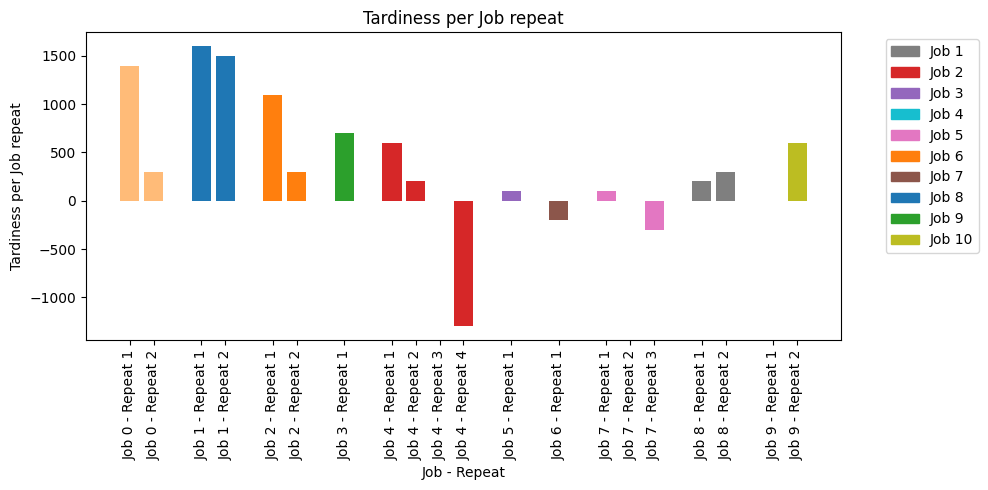

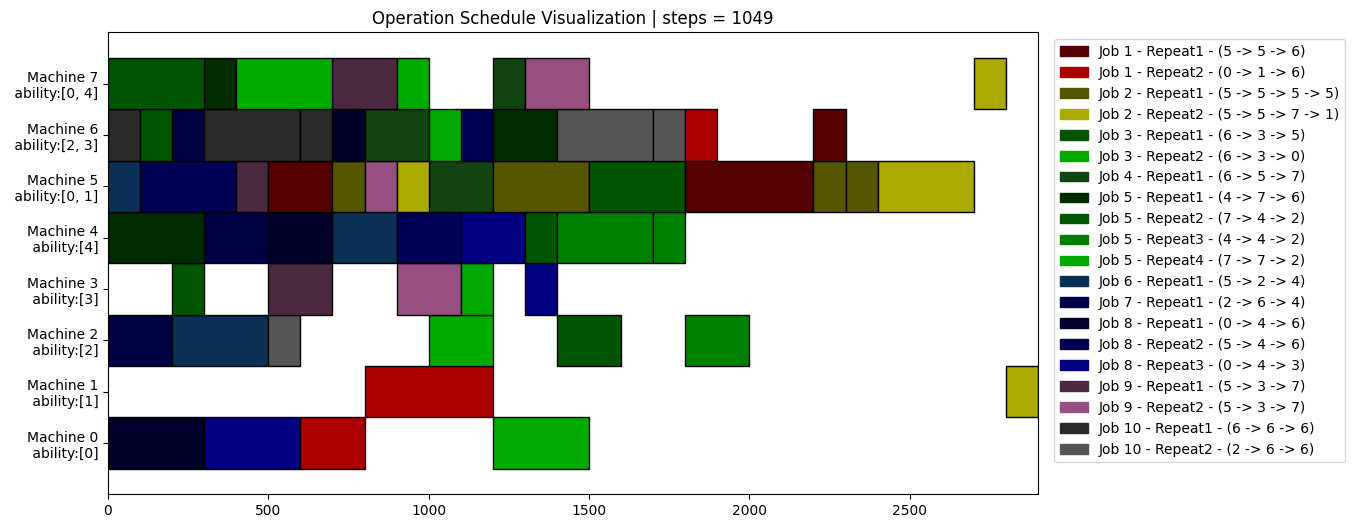

In [6]:
# random policy

obs, info = train_env.reset()
while True:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
    done = terminated or truncated
    if done:
        # print("Goal reached!", "final score=", reward)
        # print('job_deadline', info['job_deadline'])
        # print('job_time_exceeded', info['job_time_exceeded'])
        # print('current_repeats', info['current_repeats'])
        # print(env1.target_time)
        info["reward"] = reward
        info["env"] = train_env
        info["profit_ratio"] = train_env.profit_per_time
        train_env.print_result(info, detail_mode=False)
        train_env.render()
        break

In [7]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

eval_env = make_env(repeat, SchedulingEnv, test_mode=False)


def env1_lambda(): return eval_env


env_list = [env1_lambda]
# Create the evaluation environment
eval_env = SubprocVecEnv(env_list)

# Create the EvalCallback
eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                                     log_path=log_path, eval_freq=10000, n_eval_episodes=10,
                                     deterministic=True, render=False)

Logging to ./logs/tmp/1


In [8]:
# params = {
#     "policy_kwargs": dict(net_arch=[dict(pi=[1024, 256, 128], vf=[1024, 256, 64])]),
#     "gamma": 0.99,
#     "clip_range": 0.1,
#     # "n_steps": 4096,
#     "learning_rate": 3e-5,
# }
def increasing_clip_range(progress_remaining):
    return 0.1 + 0.2 * (1 - progress_remaining)


def exponential_schedule(progress_remaining):
    initial_learning_rate = 0.0003
    final_learning_rate = 0.00003
    return np.exp(
        np.log(final_learning_rate / initial_learning_rate) * (1 - progress_remaining)
    ) * initial_learning_rate


params = {
    "policy_kwargs": dict(
        # activation_fn=th.nn.LeakyReLU,
        net_arch=dict(
            pi=[512, 256, 128],
            vf=[512, 256, 128]
        ),
    ),
    "learning_rate": 5e-5,
    "gamma": 0.95,
    # "gae_lambda": 0.99,
    "n_steps": 4096,
    "batch_size": 128,
    "clip_range": 0.1,
}

model = MaskablePPO('MultiInputPolicy', vec_env,
                    policy_kwargs=params["policy_kwargs"],
                    learning_rate=params["learning_rate"],
                    gamma=params["gamma"],
                    # gae_lambda=params["gae_lambda"],
                    n_steps=params["n_steps"],
                    batch_size=params["batch_size"],
                    clip_range=params["clip_range"],
                    verbose=True
                    )

print(model.policy)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
MaskableMultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (action_masks): Flatten(start_dim=1, end_dim=-1)
      (cost_factor_per_time): Flatten(start_dim=1, end_dim=-1)
      (cur_estimated_tardiness_per_job): Flatten(start_dim=1, end_dim=-1)
      (current_costs): Flatten(start_dim=1, end_dim=-1)
      (current_repeats): Flatten(start_dim=1, end_dim=-1)
      (earliest_start_per_operation): Flatten(start_dim=1, end_dim=-1)
      (hole_length_per_machine): Flatten(start_dim=1, end_dim=-1)
      (job_deadline): Flatten(start_dim=1, end_dim=-1)
      (last_finish_time_per_machine): Flatten(start_dim=1, end_dim=-1)
      (machine_ability): Flatten(start_dim=1, end_dim=-1)
      (mappable_machine_count_per_type): Flatten(start_dim=1, end_dim=-1)
      (mean_deadline_per_job): Flatten(start_dim=1, end_dim=-1)
      (mean_estimated_tardiness

In [9]:
model.set_logger(new_logger)
model.learn(4_000_000, callback=eval_callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 79.1     |
|    ep_rew_mean     | 2.36     |
| time/              |          |
|    fps             | 534      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 79           |
|    ep_rew_mean          | 4.76         |
| time/                   |              |
|    fps                  | 465          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0020218275 |
|    clip_fraction        | 0.0522       |
|    clip_range           | 0.1          |
|    entropy_loss         | -2.64        |
|    explained_variance   | 0.0175       |
|    learning_r

In [10]:
env1 = make_env(repeat, SchedulingEnv, test_mode=True)
env2 = make_env(repeat, SchedulingEnv, test_mode=False)

custom_env = [env1, env2]

Current Repeats			:	[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Goal reached! Final score	:	48.15
Total revenue			:	1680.00 - 871.00 = 809.00
Sum of Costs			:	871.00
Cost Deadline			:	275.00
Cost Hole			:	10.00
Cost Processing			:	336.00
Cost Makespan			:	250.00
Finish Time / Target Time	:	2500 / 2100
Average Tardiness:	143.33


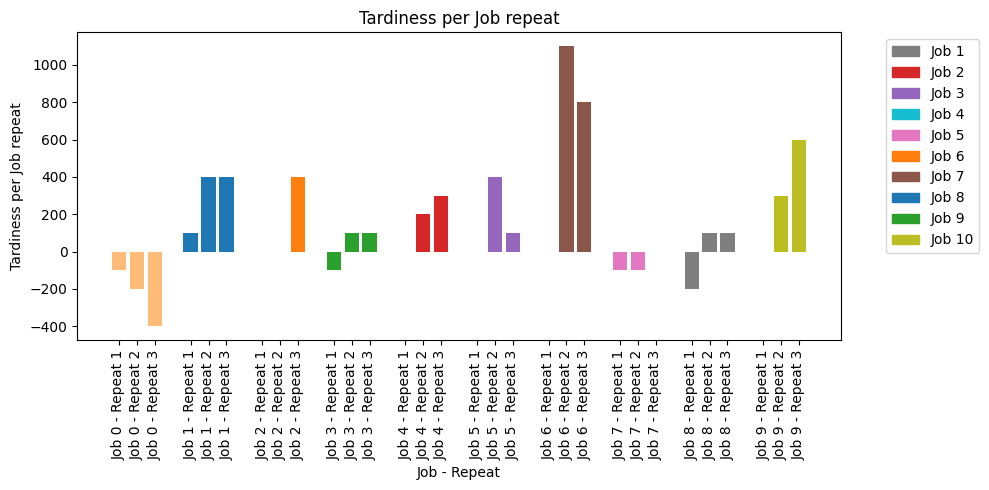

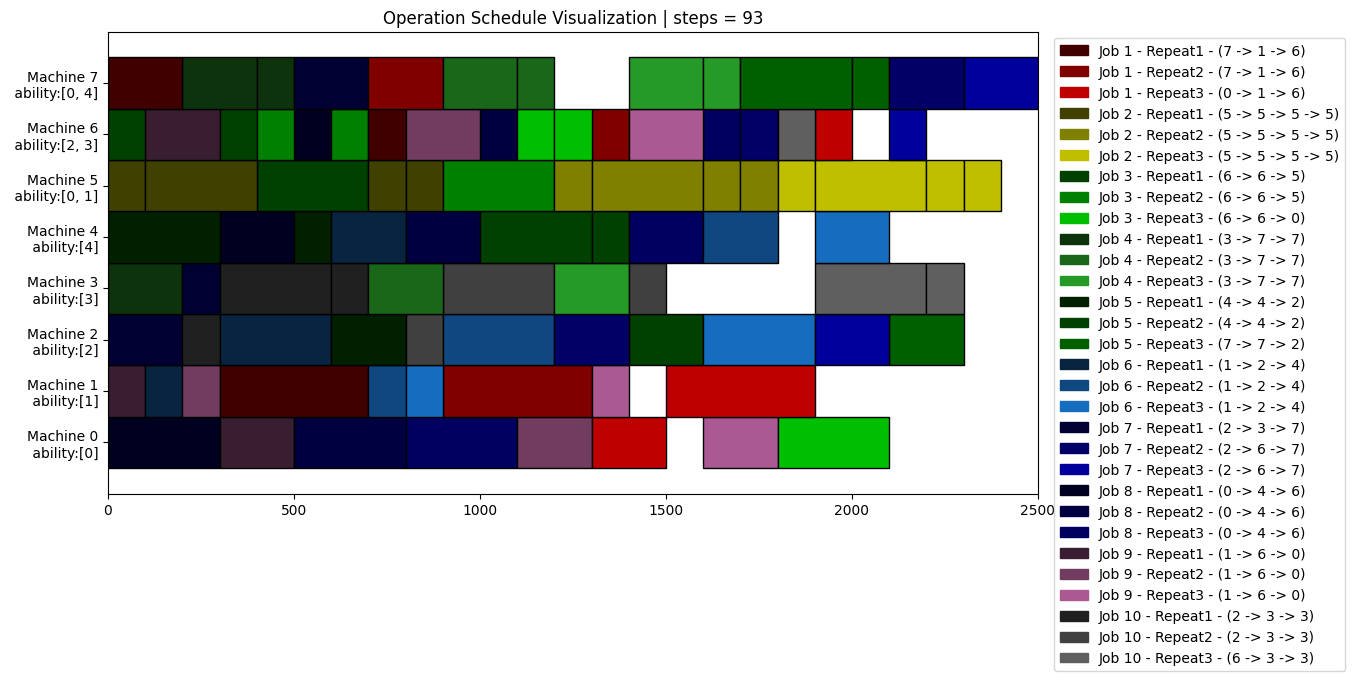

Current Repeats			:	[4, 3, 2, 2, 2, 4, 4, 2, 3, 2]
Goal reached! Final score	:	44.91
Total revenue			:	1590.00 - 876.00 = 714.00
Sum of Costs			:	876.00
Cost Deadline			:	260.00
Cost Hole			:	28.00
Cost Processing			:	318.00
Cost Makespan			:	270.00
Finish Time / Target Time	:	2700 / 1987
Average Tardiness:	103.57


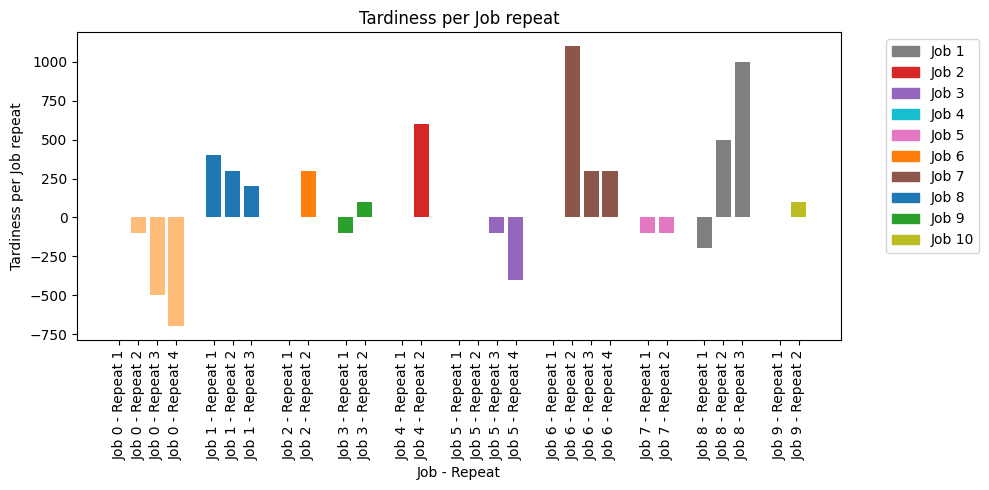

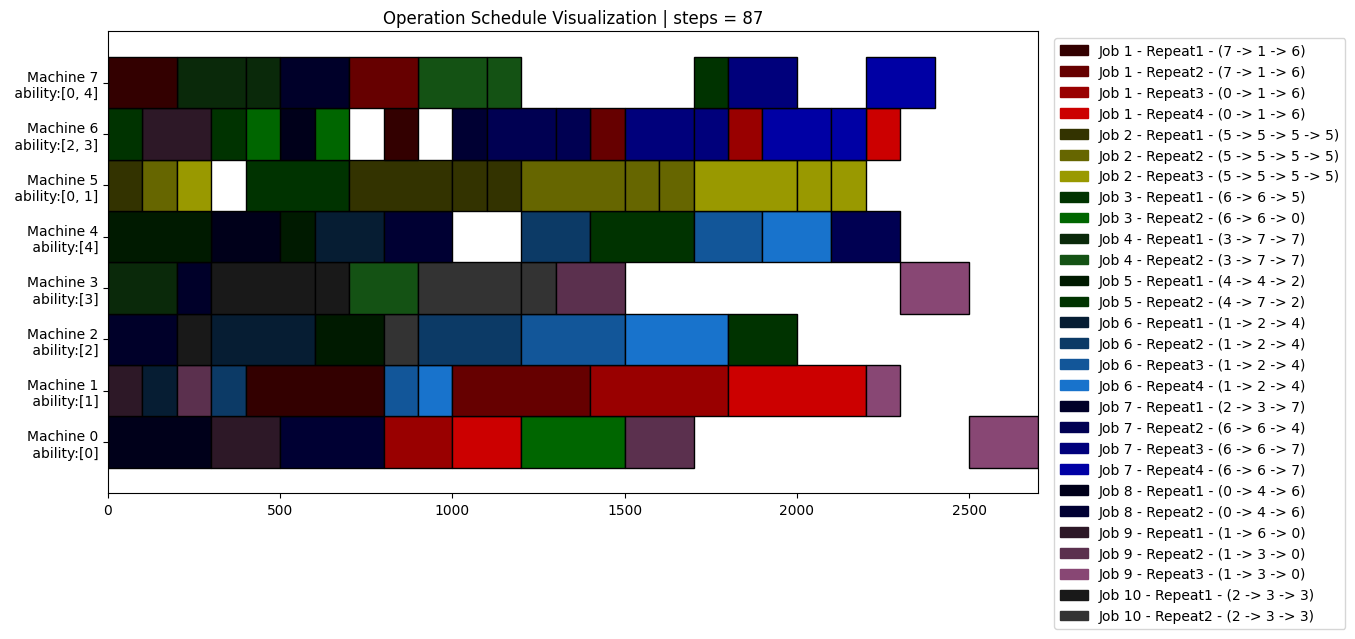

In [11]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = True, action_masks = env.action_masks())
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            # print("Goal reached!", "final score=", reward)
            # print('job_deadline', info['job_deadline'])
            # print('job_time_exceeded', info['job_time_exceeded'])
            # print('current_repeats', info['current_repeats'])
            # print(env.target_time)
            info["reward"] = reward
            info["env"] = env
            info["profit_ratio"] = env.profit_per_time
            env.print_result(info, detail_mode = False)
            env.render()
            break

In [12]:
model.save(log_path + "/final_model")

In [14]:
# # # # Additional Training

model.learn(1_000_000, callback=eval_callback)
model.save(log_path + "/final_model2")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.3        |
|    ep_rew_mean          | 49.7        |
| time/                   |             |
|    fps                  | 511         |
|    iterations           | 1           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018289924 |
|    clip_fraction        | 0.328       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.998       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.013      |
|    n_updates            | 9770        |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 0.0823      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.9  